# Decision Tree and Random Forest

This notebook carries out the Random Forest Classification Model for our Reddit data.

In [1]:
# import necessary libraries

# data manipulation libraries
import numpy as np
import scipy
import json

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# train/test split libraries
from sklearn.model_selection import train_test_split

# model libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import log_loss, accuracy_score, recall_score, precision_score, roc_auc_score

### Set Properties

In [2]:
# make sure matplotlib parameters are default
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

plt.rcParams.update({'font.size': 18})

# create custom color mapping
custom_cmap = LinearSegmentedColormap.from_list('', ['#ffffff', '#FF4500'])

# set font
plt.rcParams['font.family'] = 'Arial'

### Read in Data

In [3]:
# read in sparse representation of vocabulary
sparse_matrix = scipy.sparse.load_npz('../Data/subreddit_csr_5000.npz')

# read in vocabulary itself
with open('../Data/subreddit_vocabulary_5000.json', 'r') as file:
    vocabulary = np.array(json.load(file))

# read in class labels
with open('../Data/subreddit_classes.json', 'r') as file:
    classes = np.array(json.load(file))
classes = np.char.replace(classes, 'tifu', 'timu')

print('Shape of Sparse Matrix:', sparse_matrix.shape)
print('Length of Vocabulary:', vocabulary.shape)
print('Length of Classes:', classes.shape)

Shape of Sparse Matrix: (200000, 5000)
Length of Vocabulary: (5000,)
Length of Classes: (200000,)


### Split into Training and Testing

In [4]:
# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(sparse_matrix, classes, test_size = 0.20, random_state = 1)

# report train/test split
print(' X_train.shape:', X_train.shape)
print('  X_test.shape:', X_test.shape)
print('y_train length:', y_train.shape)
print(' y_test length:', y_test.shape)

 X_train.shape: (160000, 5000)
  X_test.shape: (40000, 5000)
y_train length: (160000,)
 y_test length: (40000,)


### Confusion Matrix Plot Function

In [36]:
# make confusion matric
def plot_confusion_matrix(confusion_matrix_var, class_labels, model_name, filename, cmap = custom_cmap, row_percent = True):
    
    # formatting
    fmt = '.0f'
    title_add = ''
    
    if row_percent == True:
        confusion_matrix_var = confusion_matrix_var / confusion_matrix_var.sum(axis=1, keepdims=True) * 100
        fmt = '.2f'
        title_add = ' (Row %)'
    
    # set plotting parameters
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams.update({'font.size': 18})
    fig, ax = plt.subplots(figsize = (10, 8))

    # plot the confusion matrix using Seaborn's heatmap
    sns.heatmap(confusion_matrix_var, annot = True, fmt = fmt, cmap = cmap, cbar = True,
                xticklabels = class_labels, yticklabels = class_labels)
    plt.xlabel('Predicted Subreddit'); plt.ylabel('True Subreddit');
    plt.title('Confusion Matrix - ' + model_name + title_add, fontweight = 'bold');
    plt.xticks(rotation = 45)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

## Classification Tree / Random Forest (Single Model)

In [50]:
# function for fitting a single tree model
def fit_single_model(model_type, filename, D = 2, row_percent = True, show_importance = False, show_tree = False):

    # assert that the model type is one of the two classifiers
    assert model_type in ['DecisionTreeClassifier', 'RandomForestClassifier'],\
        "The model type must be one of ['DecisionTreeClassifier', 'RandomForestClassifier']"
    
    # create chosen classifier
    if model_type == 'DecisionTreeClassifier':
        clf = DecisionTreeClassifier(splitter = 'best', max_depth = D, random_state = 1)
        plot_title = 'Decision Tree Model'
    else:
        clf = RandomForestClassifier(n_estimators = 100, max_depth = D, random_state = 1)
        plot_title = 'Random Forest Model'
    
    # fit the chosen classifier on the training data
    clf.fit(X_train, y_train);

    # make predictions on the test data using the classifier
    preds = clf.predict(X_test)
    pred_probs = clf.predict_proba(X_test)

    # evaluate confusion matrix and other features
    cm = confusion_matrix(y_pred = preds, y_true = y_test, labels = np.unique(y_test))

    # plot and save the confusion matrix
    plot_confusion_matrix(cm, np.unique(y_test), model_name = plot_title, filename = filename, row_percent = row_percent)

    # report overall performance
    print('Accuracy:', accuracy_score(y_true = y_test, y_pred = preds))
    print('Precision:', precision_score(y_true = y_test, y_pred = preds, average = 'weighted'))
    print('Recall:', recall_score(y_true = y_test, y_pred = preds, average = 'weighted'))
    print('ROC AUC:', roc_auc_score(y_true = y_test, y_score = pred_probs, multi_class = 'ovr'))

    # show a plot of the most important vocabulary words in the model, if requested
    if show_importance:
        # sort the word frequencies, keeping the vocabulary aligned
        importances = clf.feature_importances_
        sorted_importance = np.sort(importances)[::-1]
        sorted_vocabulary = [x for _, x in sorted(zip(importances, vocabulary))][::-1]

        # create a bar chart of variable importance by word
        # set plotting parameters
        matplotlib.rcParams.update(matplotlib.rcParamsDefault)
        plt.rcParams['font.family'] = 'Arial'
        plt.rcParams.update({'font.size': 18})
        plt.style.use('ggplot')
        fig, ax = plt.subplots(figsize = (12, 6))
        plt.bar(x = sorted_vocabulary[:10], height = sorted_importance[:10], color = '#FF4500')
        plt.xticks(rotation = 45, ha = 'right', fontsize = 16); plt.title('Variable Importance - Random Forest Model', fontsize = 18);
        plt.xlabel('Vocabulary Word', fontsize = 18); plt.ylabel('Variable Importance', fontsize = 18)
        plt.tight_layout()
        plt.savefig('../Output/RandomForestResults/random_forest_importance.png')
        plt.show()

    # show the decision tree if requested
    if show_tree:
        plt.figure(figsize = (8, 8))  # set plot size (denoted in inches)
        plot_tree(clf, fontsize = 10) # this isn't working yet
        plt.show()

### Classification Tree (First Model)

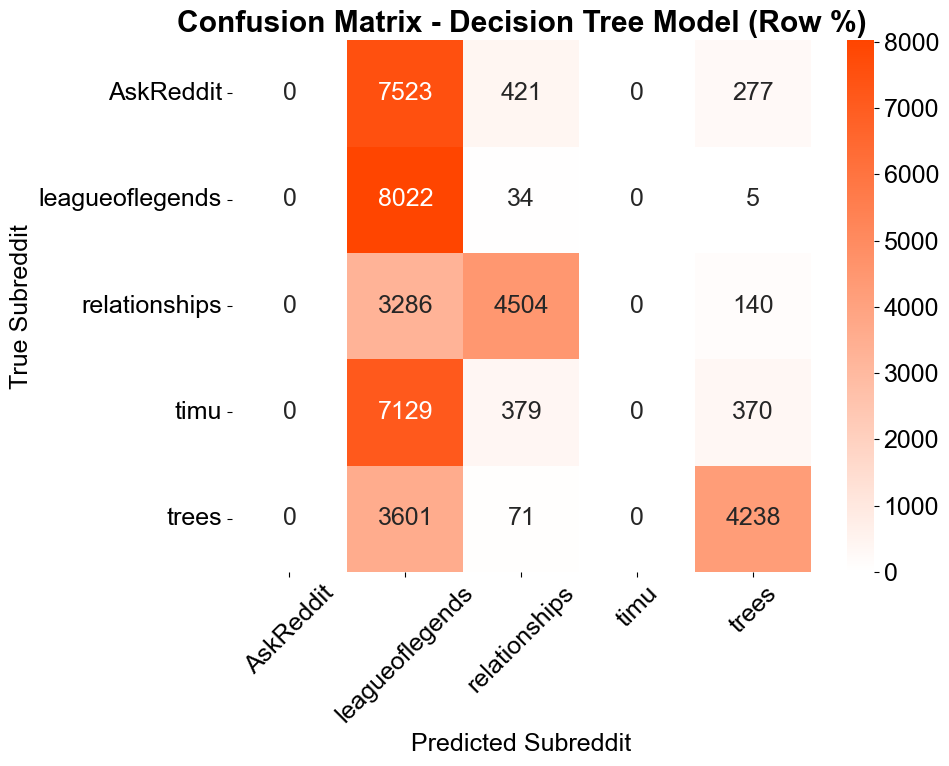

Accuracy: 0.4191
Precision: 0.3863813259579777
Recall: 0.4191
ROC AUC: 0.6932117731759275


/Users/matthewmoriarty/opt/anaconda3/envs/anly503/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
# fit the Decision Tree Classifier
fit_single_model(model_type = 'DecisionTreeClassifier', filename = '../Output/DecisionTreeResults/decision_tree_confusion_matrix.png',\
                  D = 2, row_percent = False, show_importance = False, show_tree = False)

### Random Forest (First Model)

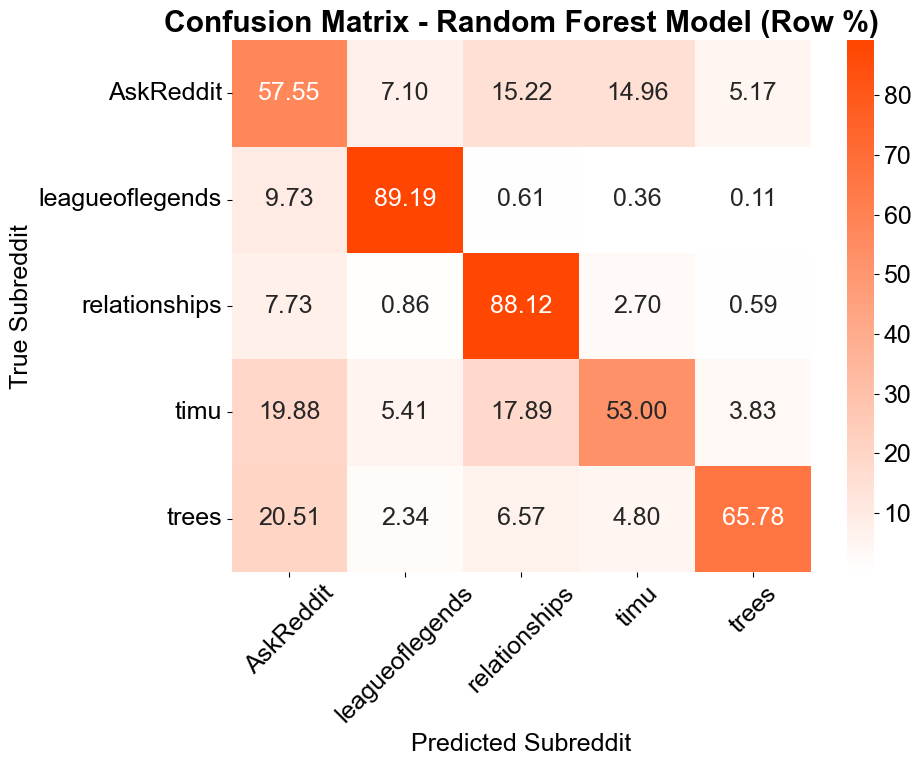

Accuracy: 0.707175
Precision: 0.719673020879421
Recall: 0.707175
ROC AUC: 0.9030041584973574


In [19]:
# fit the Random Forest Classifier
fit_single_model(model_type = 'RandomForestClassifier', filename = '../Output/RandomForestResults/random_forest_confusion_matrix.png',\
                 D = 2, row_percent = True, show_importance = False, show_tree = False)

## Classification Tree / Random Forest (Cross-Validation)

In [41]:
# function to perform cross-validation and plot resulting error and accuracy
def cross_validate_model(model_type, K = 5, D = 10):

    # assert that the model type is one of the two classifiers
    assert model_type in ['DecisionTreeClassifier', 'RandomForestClassifier'],\
        "The model type must be one of ['DecisionTreeClassifier', 'RandomForestClassifier']"

    # start matrices for storing errors and accuracies
    train_errors = np.ones(shape = (K, D))
    val_errors = np.ones(shape = (K, D))
    train_accs = np.ones(shape = (K, D))
    val_accs = np.ones(shape = (K, D))

    # define split points for identifying training versus testing folds
    split_points = np.linspace(start = 0, stop = X_train.shape[0], num = K+1)

    for k in range(K):
        # collect current test indices and data
        val_indices = list(range(int(split_points[k]), int(split_points[k+1])))
        x_val = X_train[val_indices]
        y_val = y_train[val_indices]
        # collect current train indices and data
        train_indices = list(range(int(split_points[0]), int(split_points[k])))
        rest = list(range(int(split_points[k+1]), int(split_points[K])))
        train_indices.extend(rest)
        x_t = X_train[train_indices]
        y_t = y_train[train_indices]

        # fit the chosen classifier with current hyperparameters
        for d in range(D):
        
            # create chosen classifier
            if model_type == 'DecisionTreeClassifier':
                clf = DecisionTreeClassifier(splitter = 'best', max_depth = d+1, random_state = 1)
                # plot_title = 'Decision Tree Model'
            else:
                clf = RandomForestClassifier(n_estimators = 100, max_depth = d+1, random_state = 1)
                # plot_title = 'Random Forest Model'
        
            # fit the chosen classifier
            clf.fit(x_t, y_t);

            # obtain training and validation errors
            train_probs = clf.predict_proba(x_t)
            train_errors[k, d] = log_loss(y_t, train_probs)
            val_probs = clf.predict_proba(x_val)
            val_errors[k, d] = log_loss(y_val, val_probs)

            # obtain training and validation accuracies
            train_preds = clf.predict(x_t)
            train_accs[k, d] = np.mean(train_preds == y_t)
            val_preds = clf.predict(x_val)
            val_accs[k, d] = np.mean(val_preds == y_val)

    # average the errors and accuracies across all folds
    train_errors = np.mean(train_errors, axis = 0)
    val_errors = np.mean(val_errors, axis = 0)
    train_accs = np.mean(train_accs, axis = 0)
    val_accs = np.mean(val_accs, axis = 0)

    return train_errors, val_errors, train_accs, val_accs

# function to plot results of cross validation
def plot_results(train_errors, val_errors, train_accs, val_accs, plot_title, filename):

    D = len(train_errors)

    # set plotting parameters
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams.update({'font.size': 18})

    # create two subplots
    # fig, ax = plt.subplots(1, 2, figsize = (20, 8))
    fig, ax = plt.subplots(1, 1, figsize = (10, 8))

    ax.plot(list(range(1, D+1)), train_errors, color = '#000000')
    ax.plot(list(range(1, D+1)), val_errors, color = '#FF4500')
    ax.legend(['Training', 'Validation'])
    ax.set_xlabel('Maximum Depth'); ax.set_ylabel('Categorical Cross-Entropy'); ax.set_title('Error - ' + plot_title);

    # plot the training and validation accuracies
    # ax[1].plot(list(range(1, D+1)), train_accs, color = '#000000')
    # ax[1].plot(list(range(1, D+1)), val_accs, color = '#FF4500')
    # ax[1].legend(['Training', 'Validation'])
    # ax[1].set_xlabel('Maximum Depth'); ax[1].set_ylabel('Overall Accuracy'); ax[1].set_title('Accuracy - ' + plot_title);

    plt.savefig(filename)
    plt.show()

In [21]:
# cross-validate the decision tree model
train_errors, val_errors, train_accs, val_accs = cross_validate_model(model_type = 'DecisionTreeClassifier', K = 5, D = 10)

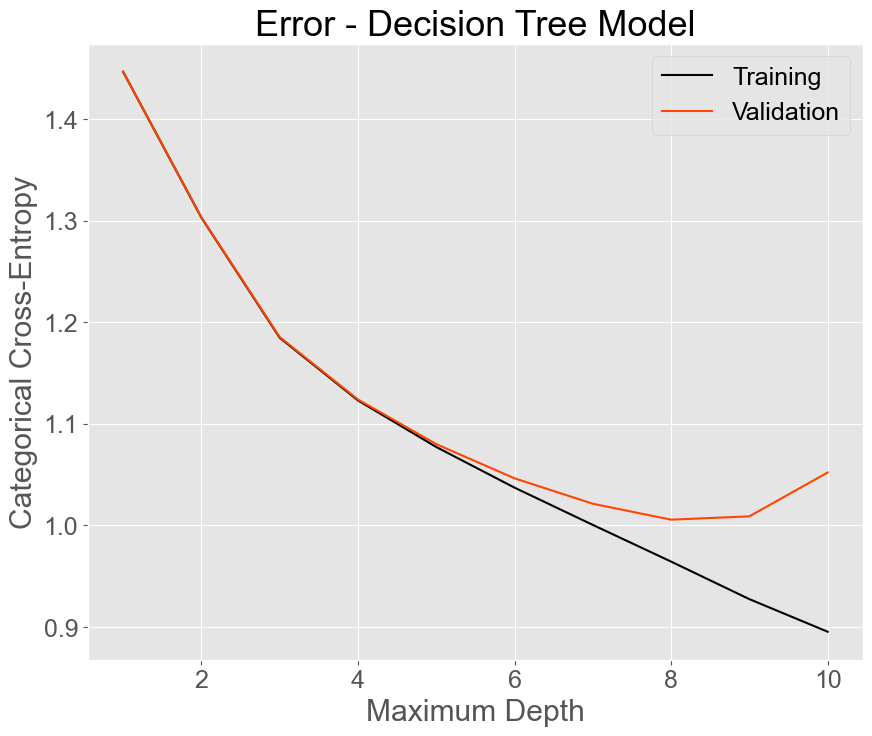

In [42]:
# plot the results
plot_results(train_errors, val_errors, train_accs, val_accs, 'Decision Tree Model', '../Output/DecisionTreeResults/decision_tree_cv.png')

In [23]:
# cross-validate the random forest model
train_errors2, val_errors2, train_accs2, val_accs2 = cross_validate_model(model_type = 'RandomForestClassifier', K = 5, D = 10)

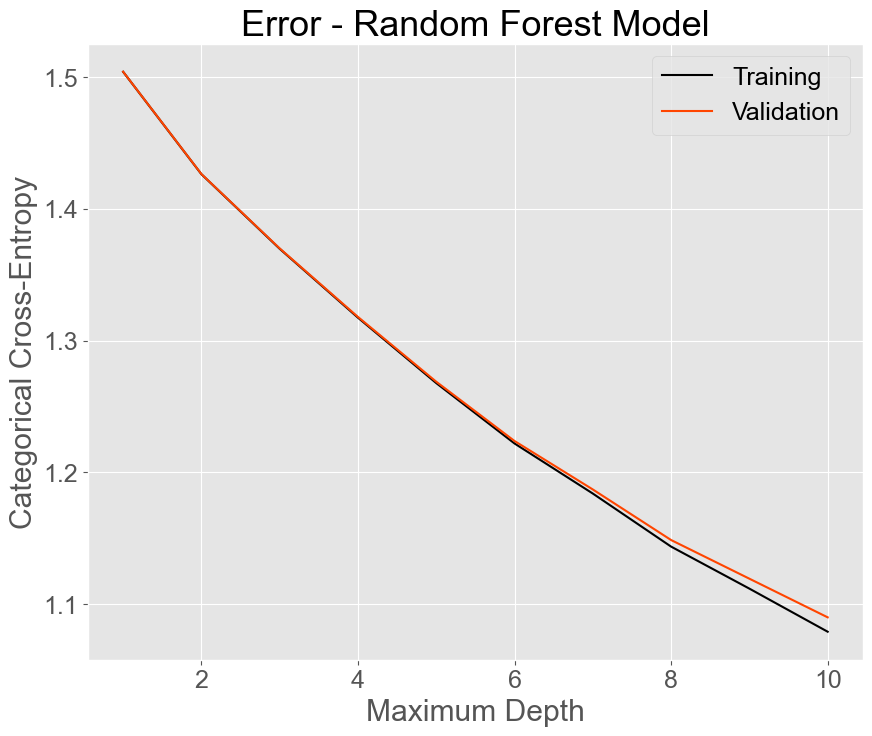

In [43]:
# plot the results
plot_results(train_errors2, val_errors2, train_accs2, val_accs2, 'Random Forest Model', '../Output/RandomForestResults/random_forest_cv.png')

### EXTRA CROSS VALIDATION PLOT

In [27]:
# function to plot results of cross validation
def plot_results(train_errors, val_errors, train_errors2, val_errors2, filename):

    D = len(train_errors)

    # set plotting parameters
    matplotlib.rcParams.update(matplotlib.rcParamsDefault)
    plt.style.use('ggplot')
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams.update({'font.size': 16})

    # create two subplots
    fig, ax = plt.subplots(1, 2, figsize = (16, 4))

    ax[0].plot(list(range(1, D+1)), train_errors, color = '#000000')
    ax[0].plot(list(range(1, D+1)), val_errors, color = '#FF4500')
    ax[0].legend(['Training', 'Validation'])
    ax[0].set_xlabel('Maximum Depth'); ax[0].set_ylabel('Categorical Cross-Entropy'); ax[0].set_title('Error - Decision Tree Model', fontsize = 16);

    # plot the training and validation accuracies
    ax[1].plot(list(range(1, D+1)), train_errors2, color = '#000000')
    ax[1].plot(list(range(1, D+1)), val_errors2, color = '#FF4500')
    ax[1].legend(['Training', 'Validation'])
    ax[1].set_xlabel('Maximum Depth'); ax[1].set_ylabel('Categorical Cross-Entropy'); ax[1].set_title('Error - Random Forest Model', fontsize = 16);

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

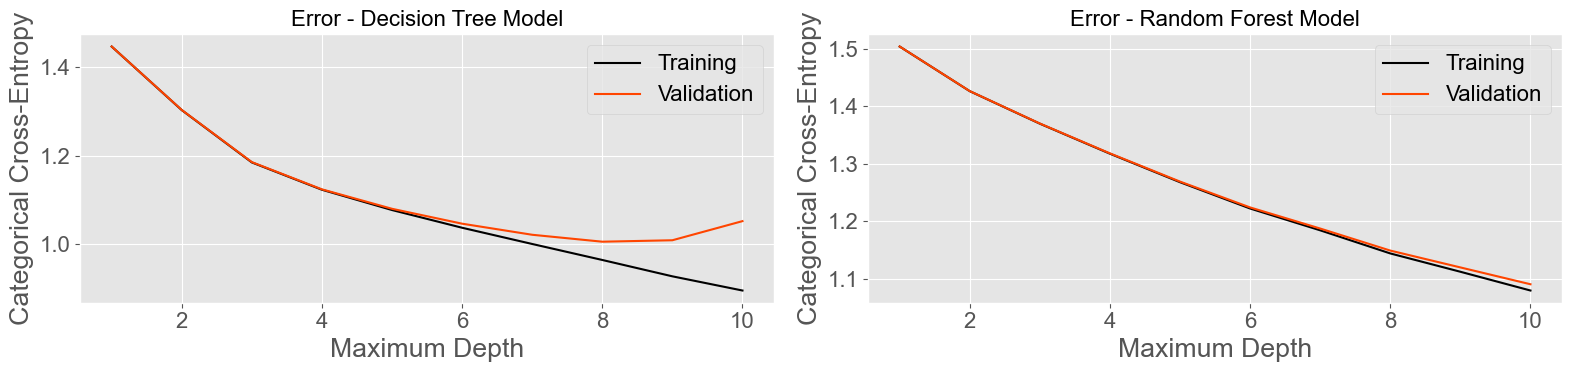

In [28]:
plot_results(train_errors, val_errors, train_errors2, val_errors2, '../Output/RandomForestResults/both_trees_cv.png')

## Classification Tree / Random Forest (Final Model)

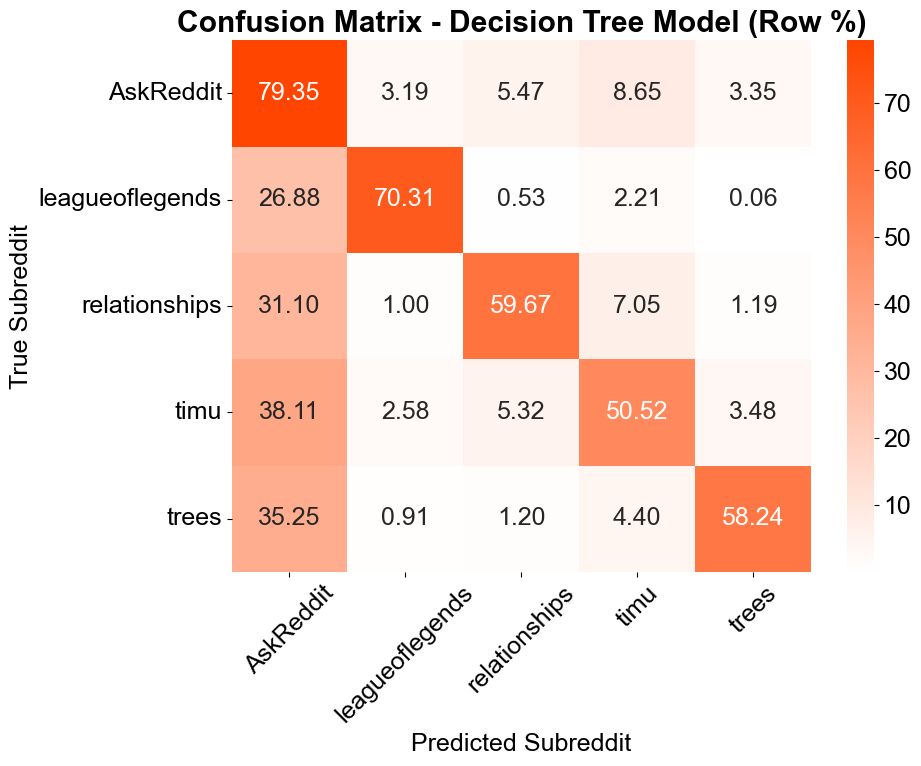

Accuracy: 0.63775
Precision: 0.733421686554688
Recall: 0.63775
ROC AUC: 0.8532601357381084


In [38]:
# fit the Decision Tree Classifier
fit_single_model(model_type = 'DecisionTreeClassifier', filename = '../Output/DecisionTreeResults/decision_tree_confusion_matrix_pct.png',\
                  D = 8, row_percent = True, show_importance = False, show_tree = False)

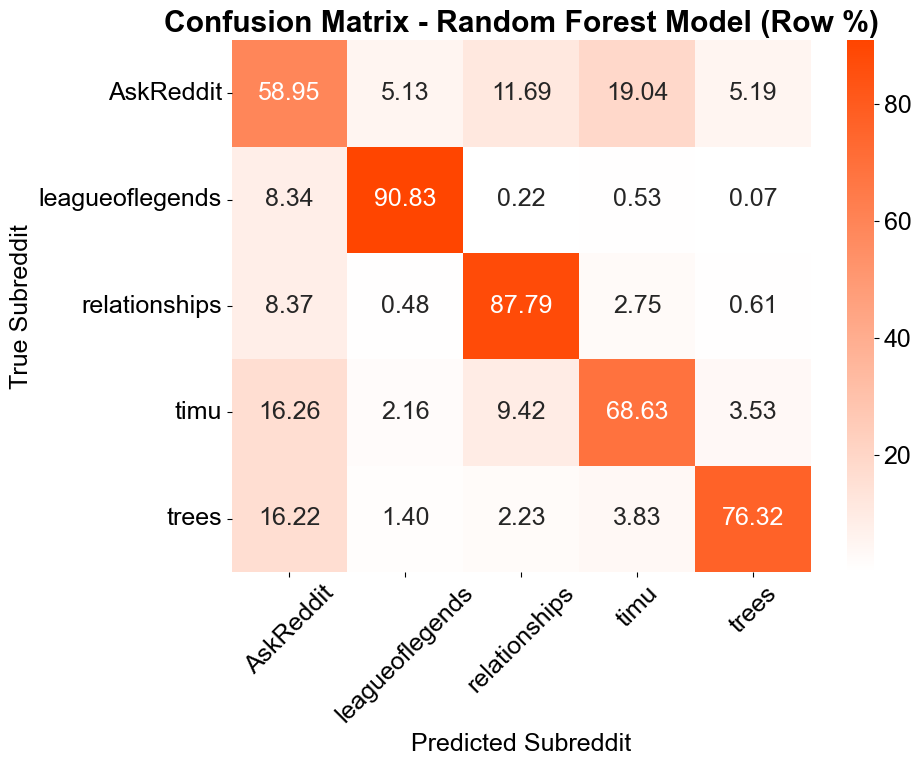

Accuracy: 0.76435
Precision: 0.7696546514927587
Recall: 0.76435
ROC AUC: 0.9332938134012527


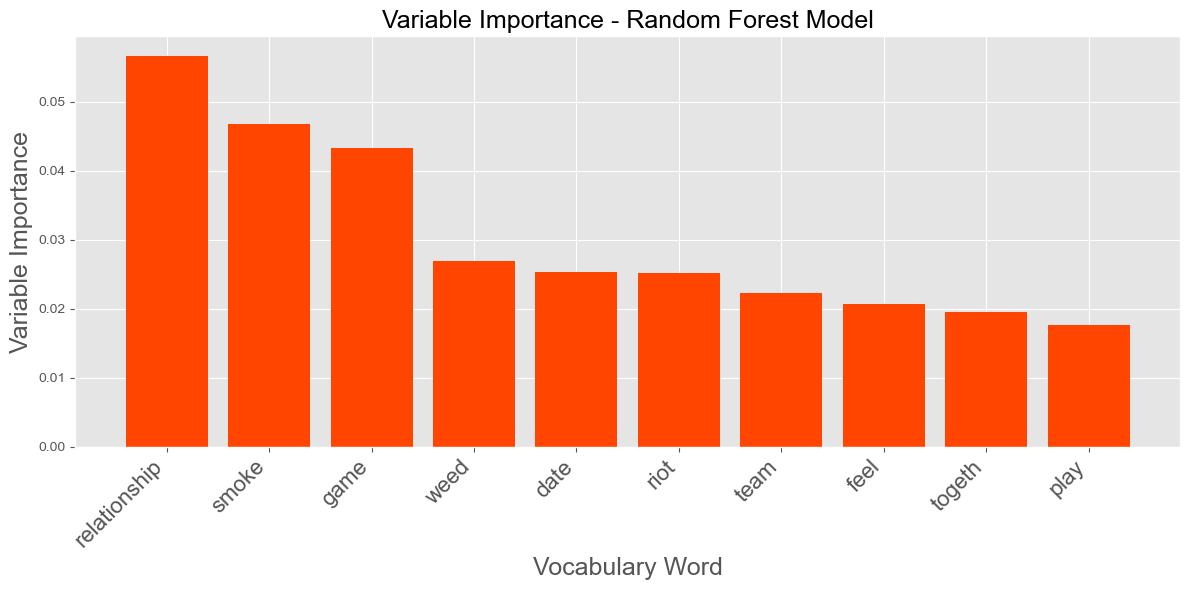

In [51]:
# fit the Random Forest Classifier
fit_single_model(model_type = 'RandomForestClassifier', filename = '../Output/RandomForestResults/random_forest_confusion_matrix_pct.png',\
                 D = 10, row_percent = True, show_importance = True, show_tree = False)